In [2]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.image import imread
from pathlib import Path
from skimage.io import imread
from PIL import Image
from typing import Union, Tuple

#------ALL FUNCTIONS NEEDED------

# Mean filter
def mean_filter(image, kernel_size = 3) -> np.ndarray:
    """
    Apply a mean filter (box blur) to a 2D grayscale image using only NumPy.

    Parameters
    ----------
    image : np.ndarray
        2D array of the grayscale image.
    kernel_size : int
        Size of the (square) kernel; must be odd.

    Returns
    -------
    filtered : np.ndarray
        The blurred image, same shape as input.
    """
    if kernel_size % 2 == 0:
        raise ValueError("kernel_size must be odd.")
    pad = kernel_size // 2
    # Spiegele die Ränder, damit wir auch am Rand filtern können
    img_padded = np.pad(image, pad, mode='reflect')
    H, W = image.shape
    filtered = np.empty_like(image, dtype=float)

    # Summen-Integralbild zur schnellen Fenster-Summen
    # Integralbild hat eine zusätzliche Null-Zeile/-Spalte vorne
    integral = np.cumsum(np.cumsum(img_padded, axis=0), axis=1)
    # Schleife über alle Pixel
    for i in range(H):
     for j in range(W):
      window = img_padded[i:i+kernel_size, j:j+kernel_size]
      filtered[i,j] = window.sum() / (kernel_size**2)
    return filtered

# creating histogram for Otsu threshholding  
def custom_histogram(image: np.ndarray, nbins: int = 256) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the histogram and corresponding bin centers of a grayscale image,
    replicating the behavior of skimage.exposure.histogram, including normalization
    to the [0, 255] range. This ensures consistent behavior with Otsu implementations
    that assume 8-bit images.

    Args:
        image (np.ndarray): Input image as a 2D array of grayscale values.
        nbins (int): Number of bins for the histogram (default: 256).

    Returns:
        hist (np.ndarray): Array of histogram frequencies for each bin.
        bin_centers (np.ndarray): Array of bin center values.
    """
    # Determine the minimum and maximum pixel intensity in the image
    img_min, img_max = image.min(), image.max()

    # Normalize the image intensities to the range [0, 255], as in skimage
    image_scaled = ((image - img_min) / (img_max - img_min) * 255).astype(np.uint8)

    # Compute the histogram of the scaled image within [0, 255]
    hist, bin_edges = np.histogram(
        image_scaled.ravel(),
        bins=nbins,
        range=(0, 255)
    )

    # Compute bin centers as the average of adjacent bin edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return hist, bin_centers

# Otsu thresholding
def apply_global_otsu(image: np.ndarray) -> float:
    """
    Computes the global Otsu threshold of an input grayscale image in a way that matches
    the behavior of skimage.filters.threshold_otsu, including histogram scaling and
    threshold rescaling back to the original intensity range.

    This function enables nearly identical thresholding results to skimage's implementation,
    even on images with floating-point or non-8-bit integer data.

    Args:
        image (np.ndarray): Input image as a 2D array of grayscale values.

    Returns:
        threshold_original (float): Computed Otsu threshold mapped back to the original image range.
    """
    # Compute histogram and bin centers consistent with skimage
    hist, bin_centers = custom_histogram(image, nbins=256)
    hist = hist.astype(np.float64)

    # Normalize histogram to obtain probability distribution p(k)
    p = hist / hist.sum()

    # Compute cumulative sums of class probabilities ω0 and ω1
    omega0 = np.cumsum(p)                           # Class probabilities for background
    omega1 = np.cumsum(p[::-1])[::-1]               # Class probabilities for foreground

    # Compute cumulative sums of class means μ0 and μ1
    mu0 = np.cumsum(p * bin_centers)                # Class means for background
    mu1 = np.cumsum((p * bin_centers)[::-1])[::-1]  # Class means for foreground

    # Compute between-class variance σ_b^2 for each possible threshold
    sigma_b_squared = (omega0[:-1] * omega1[1:] * (mu0[:-1] / omega0[:-1] - mu1[1:] / omega1[1:])**2)

    # Find the threshold index t maximizing σ_b^2
    t_idx = np.argmax(sigma_b_squared)
    t_scaled = bin_centers[t_idx]

    # Rescale threshold t back to original image intensity range
    img_min, img_max = image.min(), image.max()
    t_original = t_scaled / 255 * (img_max - img_min) + img_min

    return (image > t_original).astype(np.uint8)

# Dice score
def dice_score(otsu_img, otsu_gt):

    # control if the Pictures have the same Size
    if len(otsu_img) != len(otsu_gt):
       if len(otsu_img) > len(otsu_gt):
         otsu_img = otsu_img[1:len(otsu_gt)]
       else:
        otsu_gt = otsu_gt[1:len(otsu_img)]


    # defining the variables for the Dice Score equation
    positive_overlap = 0
    sum_img = 0
    sum_gt = 0

    for t, p in zip(otsu_img, otsu_gt):
        if t == 1:
            sum_img += 1
        if p == 1:
            sum_gt += 1
        if t == 1 and p == 1:
            positive_overlap += 1

    if sum_img + sum_gt == 0:
        return 1.0

    return 2 * positive_overlap / (sum_img + sum_gt)

# Process single image and its groundtruth
def process_single(img_path: Path, gt_path: Path, s) -> float:
    """ 
    Reads one image and corresponding groundtruth, proccesses, segments and computes dice score for one image.
    """
    # Reads image and reads, binarizes groundtruth
    img = imread(img_path, as_gray=True)
    gt = imread(gt_path, as_gray=True)
    gt  = 1 - (gt == 0)         

    # Mean filter
    img_filtered = mean_filter(img, kernel_size=s)

    # 1nd Otsu
    binary1 = apply_global_otsu(img_filtered)

    if np.mean(binary1)>0.5:
        binary1 = ~binary1

    # 5. Compute Dice score
    return dice_score(binary1.flatten(), gt.flatten())

# -------------------------------------------------------------------
# Mainroutine: Going through all image-gt pairs and collect all dice scores of data set: NIH3T3
# -------------------------------------------------------------------

# Define window sizes to test (e.g., from 3 to 21 in steps of 2)
window_sizes = np.arange(3, 51, 2)

# Set paths
img_dir = Path("data/NIH3T3/img")
gt_dir  = Path("data/NIH3T3/gt")

# Loop over window sizes
dice_score_means_NIH3T3 = []

for size in window_sizes:
    dice_scores = []

    for img_file in sorted(img_dir.glob("dna-*.png")):
        idx = img_file.stem.split('-')[-1]
        gt_file = gt_dir / f"{idx}.png"

        # Compute Dice score for current image and window size
        score = process_single(img_file, gt_file, s=size)
        dice_scores.append(score)

    # Convert to numpy array and print mean
    dice_scores = np.array(dice_scores)
    dice_score_mean = np.mean(dice_scores)
    print(f"wien {size:.2f} → Mean Dice: {dice_scores.mean():.4f}")
    dice_score_means_NIH3T3.append(dice_score_mean)

np.save('NIH3T3_dice_means_meanfilter', dice_score_means_NIH3T3)
    
# NEXT

# Set paths
img_dir = Path("data/N2DL-HeLa/img")
gt_dir  = Path("data/N2DL-HeLa/gt")

# Loop over window sizes
dice_score_means_N2DL_HeLa = []

for size in window_sizes:
    dice_scores = []

    for img_file in sorted(img_dir.glob("t-*.tif")):
        idx = img_file.stem.split('-')[-1]
        gt_file = gt_dir / f"man_seg{idx}.tif"

        # Compute Dice score for current image and window size
        score = process_single(img_file, gt_file, s=size)
        dice_scores.append(score)

    # Convert to numpy array and print mean
    dice_scores = np.array(dice_scores)
    dice_score_mean = np.mean(dice_scores)
    print(f"wien {size:.2f} → Mean Dice: {dice_scores.mean():.4f}")
    dice_score_means_N2DL_HeLa.append(dice_score_mean)

np.save('N2DL-HeLa_dice_means_meanfilter', dice_score_means_N2DL_HeLa)


# NEXT

# Set paths
img_dir = Path("data/N2DH-GOWT1/img")
gt_dir  = Path("data/N2DH-GOWT1/gt")

# Loop over gamma values
dice_score_means_N2DH_GOWT1 = []

for size in window_sizes:
    dice_scores = []

    for img_file in sorted(img_dir.glob("t-*.tif")):
        idx = img_file.stem.split('-')[-1]
        gt_file = gt_dir / f"man_seg{idx}.tif"

        # Compute Dice score for current image and window size
        score = process_single(img_file, gt_file, s=size)
        dice_scores.append(score)

    # Convert to numpy array and print mean
    dice_scores = np.array(dice_scores)
    dice_score_mean = np.mean(dice_scores)
    print(f"wien {size:.2f} → Mean Dice: {dice_scores.mean():.4f}")
    dice_score_means_N2DH_GOWT1.append(dice_score_mean)

np.save('N2DH-GOWT1_dice_means_meanfilter', dice_score_means_N2DH_GOWT1)

wien 3.00 → Mean Dice: 0.5242
wien 5.00 → Mean Dice: 0.5237
wien 7.00 → Mean Dice: 0.5251
wien 9.00 → Mean Dice: 0.5245
wien 11.00 → Mean Dice: 0.5235
wien 13.00 → Mean Dice: 0.5224
wien 15.00 → Mean Dice: 0.5201
wien 17.00 → Mean Dice: 0.5195
wien 19.00 → Mean Dice: 0.5163
wien 21.00 → Mean Dice: 0.5155
wien 23.00 → Mean Dice: 0.5141
wien 25.00 → Mean Dice: 0.5410
wien 27.00 → Mean Dice: 0.5390
wien 29.00 → Mean Dice: 0.5380
wien 31.00 → Mean Dice: 0.5340
wien 33.00 → Mean Dice: 0.5324
wien 35.00 → Mean Dice: 0.5287
wien 37.00 → Mean Dice: 0.5265
wien 39.00 → Mean Dice: 0.5254
wien 41.00 → Mean Dice: 0.5219
wien 43.00 → Mean Dice: 0.5177
wien 45.00 → Mean Dice: 0.5158
wien 47.00 → Mean Dice: 0.5130
wien 49.00 → Mean Dice: 0.5104
wien 3.00 → Mean Dice: 0.7212
wien 5.00 → Mean Dice: 0.7221
wien 7.00 → Mean Dice: 0.7189
wien 9.00 → Mean Dice: 0.7222
wien 11.00 → Mean Dice: 0.7245
wien 13.00 → Mean Dice: 0.7283
wien 15.00 → Mean Dice: 0.7286
wien 17.00 → Mean Dice: 0.7222
wien 19.00 → Mea

Optimal window size: 15.00 Mean dice = 0.6214


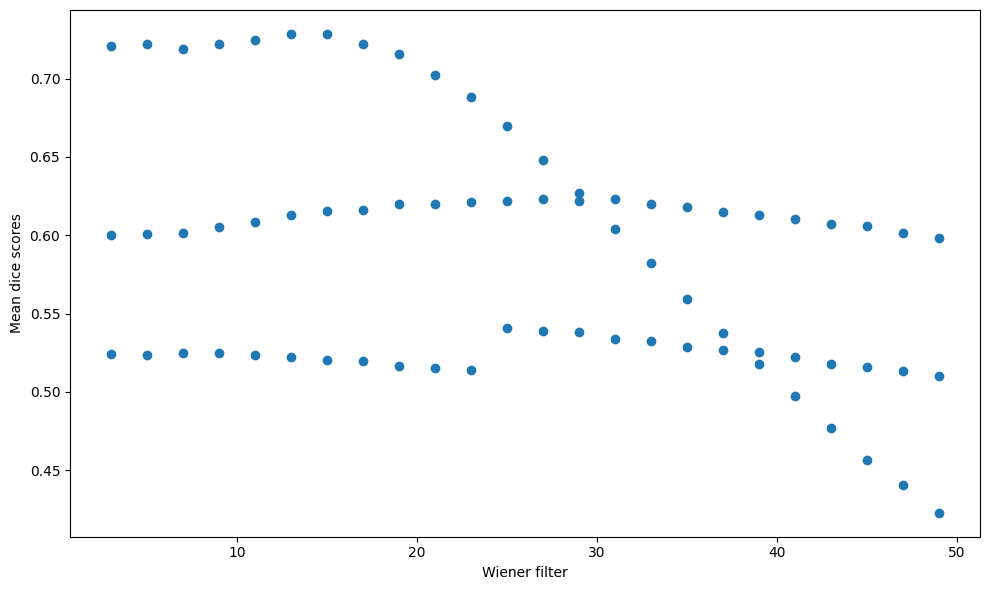

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#------------------------------------------------------
#PLOT FOR mean dice score in dependency of window size
#------------------------------------------------------


# Define indices for the labels of the later x-axis 
window_sizes = np.arange(3, 51, 2)

x = np.concatenate((window_sizes, window_sizes, window_sizes))

# Load the Dice scores from Otsu-only into one array, and those from mean filter into another
# Loading

NIH3T3_dice = np.load('NIH3T3_dice_means_meanfilter.npy')
N2DL_HeLa_dice = np.load('N2DL-HeLa_dice_means_meanfilter.npy')
N2DH_GOWT1_dice = np.load('N2DH-GOWT1_dice_means_meanfilter.npy')



# Combining
all_dice_means_wiener = np.concatenate((NIH3T3_dice, N2DL_HeLa_dice, N2DH_GOWT1_dice))

# Find the best window size

# Combine all vectors into 2d array (Columns: the datasets, rows: the window size)
all_means = np.vstack([NIH3T3_dice, N2DL_HeLa_dice, N2DH_GOWT1_dice]).T

# Calculate the mean of each window size across all datasets (mean of rows)
mean_across_datasets = all_means.mean(axis=1)  # shape = (len(gamma_values),)

# Find the index of the maximum row mean
best_idx = np.argmax(mean_across_datasets)

# Use index to find the best window size
best_meanfilter = window_sizes[best_idx]
best_dice  = mean_across_datasets[best_idx]

print(f"Optimal window size: {best_meanfilter:.2f} Mean dice = {best_dice:.4f}")



# Create scatter plot
plt.figure(figsize=(10,6))
plt.scatter(x, all_dice_means_wiener)

plt.xlabel('Wiener filter')
plt.ylabel('Mean dice scores')
plt.title('')
plt.tight_layout()
plt.show()